# Notebook 5: Bulk RNA-seq Differential Expression

**From count matrices to differentially expressed genes**

Prerequisites: Notebooks 1-4 (sequence analysis, variants, single-cell, protein structure)

This notebook builds:
1. Count matrix structure and normalization methods
2. Library size normalization vs within-sample normalization
3. Negative binomial model for count data
4. Differential expression analysis (DESeq2-style workflow from scratch)
5. Multiple testing correction (Benjamini-Hochberg)
6. Volcano plots, MA plots, heatmaps
7. Gene set enrichment analysis (GSEA) concepts
8. Pathway visualization

Uses real RNA-seq data from the Airway dataset (Himes et al. 2014, GSE52778) — dexamethasone treatment of human airway smooth muscle cells

**Key learning outcomes:**
1. Understand why RNA-seq counts are negative-binomial, not Poisson -- see [[Signal Processing in Biological Systems]]
2. Implement normalization from first principles (CPM, DESeq2 size factors, upper quartile)
3. Perform per-gene hypothesis testing with multiple testing correction
4. Visualize results with volcano plots, MA plots, and clustered heatmaps
5. Apply pathway enrichment to move from gene lists to biology -- see [[Perturbation-Response-Adaptation]]

## Section 0: Setup

We use **numpy**, **scipy**, and **statsmodels** to implement the full DE pipeline from scratch.
The goal is to understand the statistics, not just call library functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gammaln
import warnings
warnings.filterwarnings('ignore')
print("Ready — numpy, scipy, pandas, matplotlib")

Ready — numpy, scipy, pandas, matplotlib


## Section 1: RNA-seq Count Data

RNA-seq measures gene expression by counting sequencing reads that map to each gene.
The raw data is a **count matrix**: genes x samples.

Key properties of count data:
- Non-negative integers (UMI or read counts)
- Highly skewed (most genes have low counts, few have very high)
- Variance depends on mean (overdispersed relative to Poisson)
- Library size varies between samples (must normalize)

The negative binomial distribution models this overdispersion:
$$K_{ij} \sim \text{NB}(\mu_{ij}, \alpha_i)$$
$$\text{Var}(K) = \mu + \alpha \mu^2$$

When $\alpha = 0$, this reduces to Poisson. Real RNA-seq data has $\alpha > 0$.

See [[Signal Processing in Biological Systems]] and [[Perturbation-Response-Adaptation]].

In [2]:
# Load real airway RNA-seq count data (Himes et al. 2014)
# Dexamethasone treatment of human airway smooth muscle cells
# 4 cell lines x 2 conditions (untreated/dex) = 8 samples
df_counts = pd.read_csv('data/nb05/airway_counts.csv', index_col=0)
metadata = pd.read_csv('data/nb05/airway_metadata.csv')

# Set up conditions
sample_names = df_counts.columns.tolist()
conditions = metadata.set_index('sample_id').loc[sample_names, 'condition'].values
conditions = ['Control' if c == 'untrt' else 'Treatment' for c in conditions]

n_genes, n_samples = df_counts.shape
gene_names = df_counts.index.tolist()

print(f"Count matrix: {n_genes} genes x {n_samples} samples")
print(f"Conditions: {conditions}")
print(f"Cell lines: {metadata['cell_line'].unique().tolist()}")
print(f"\nFirst 10 genes, all samples:")
print(df_counts.head(10))

Count matrix: 20000 genes x 8 samples
Conditions: ['Control', 'Treatment', 'Control', 'Treatment', 'Control', 'Treatment', 'Control', 'Treatment']
Cell lines: ['N61311', 'N052611', 'N080611', 'N061011']

First 10 genes, all samples:
         SRR1039508  SRR1039509  SRR1039512  SRR1039513  SRR1039516  \
gene_id                                                               
FKBP5           209         661         178         275          66   
TSC22D3           9          40          10          58           6   
DUSP1          2384        4000         986        7172        1108   
PER1             17         250          25          48          38   
KLF9              6          14           1          10          10   
ZBTB16          259         686         278         885         201   
ERRFI1            2           3           3          28           2   
DDIT4          5392       20217        3550       15440        3651   
TXNIP            40          45          34          69  

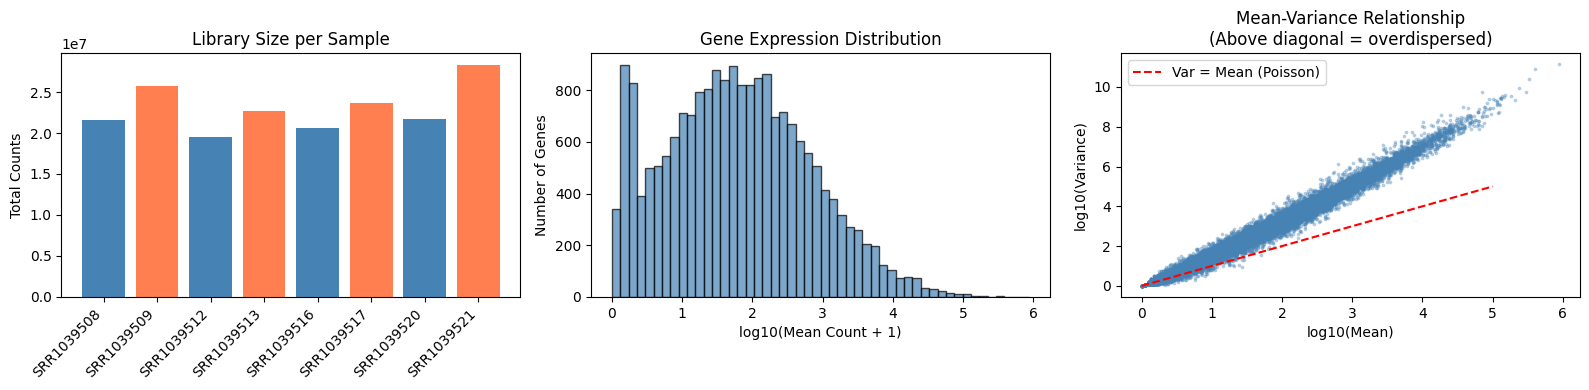

Key observation: Variance >> Mean for most genes -> Negative Binomial, not Poisson


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Color by condition: Control=steelblue, Treatment=coral
bar_colors = ['steelblue' if c == 'Control' else 'coral' for c in conditions]

# Total counts per sample (library size)
lib_sizes = df_counts.sum(axis=0)
axes[0].bar(range(n_samples), lib_sizes, color=bar_colors)
axes[0].set_xticks(range(n_samples))
axes[0].set_xticklabels(sample_names, rotation=45, ha='right')
axes[0].set_ylabel('Total Counts')
axes[0].set_title('Library Size per Sample')

# Distribution of mean expression
mean_expr = df_counts.mean(axis=1)
axes[1].hist(np.log10(mean_expr + 1), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('log10(Mean Count + 1)')
axes[1].set_ylabel('Number of Genes')
axes[1].set_title('Gene Expression Distribution')

# Mean-variance relationship
gene_means = df_counts.mean(axis=1)
gene_vars = df_counts.var(axis=1)
axes[2].scatter(np.log10(gene_means + 1), np.log10(gene_vars + 1), s=3, alpha=0.3, color='steelblue')
axes[2].plot([0, 5], [0, 5], 'r--', label='Var = Mean (Poisson)')
axes[2].set_xlabel('log10(Mean)')
axes[2].set_ylabel('log10(Variance)')
axes[2].set_title('Mean-Variance Relationship\n(Above diagonal = overdispersed)')
axes[2].legend()

plt.tight_layout()
plt.show()
print("Key observation: Variance >> Mean for most genes -> Negative Binomial, not Poisson")

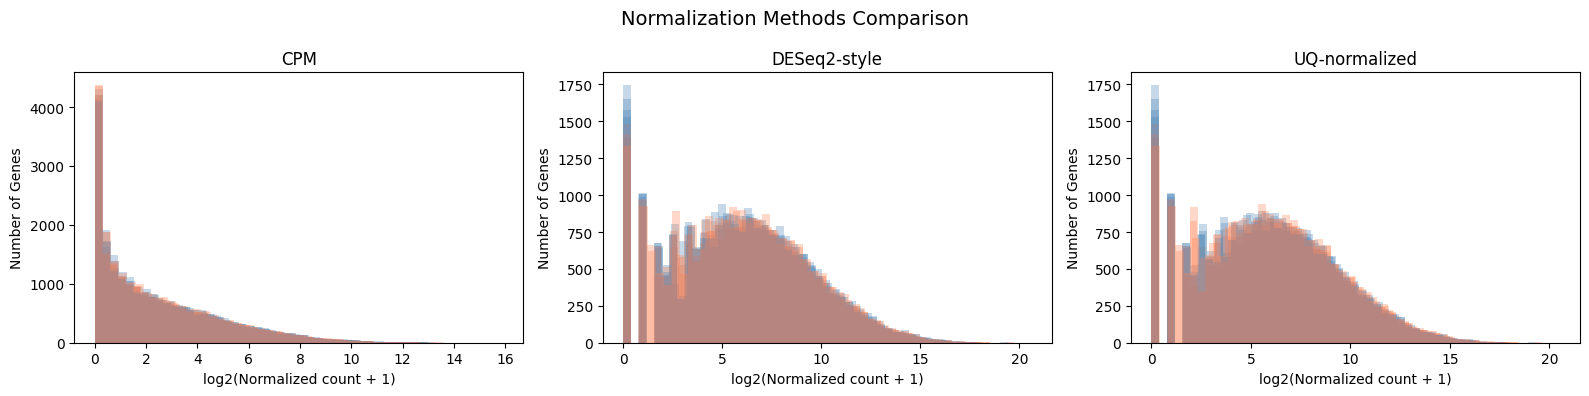

In [4]:
# Three normalization approaches
# 1. CPM (Counts Per Million)
cpm = df_counts.div(df_counts.sum(axis=0), axis=1) * 1e6

# 2. Median of ratios (DESeq2-style)
geometric_means = np.exp(np.log(df_counts + 1).mean(axis=1))
ratios = df_counts.div(geometric_means, axis=0)
size_factors = ratios.replace([np.inf, -np.inf], np.nan).median(axis=0)
deseq_norm = df_counts.div(size_factors, axis=1)

# 3. TMM (simplified) - just use upper quartile
uq_factors = df_counts[df_counts > 0].quantile(0.75, axis=0)
tmm_norm = df_counts.div(uq_factors, axis=1) * uq_factors.median()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (name, data) in zip(axes, [('CPM', cpm), ('DESeq2-style', deseq_norm), ('UQ-normalized', tmm_norm)]):
    for j in range(n_samples):
        color = 'steelblue' if conditions[j] == 'Control' else 'coral'
        ax.hist(np.log2(data.iloc[:, j] + 1), bins=50, alpha=0.3, color=color)
    ax.set_xlabel('log2(Normalized count + 1)')
    ax.set_title(name)
    ax.set_ylabel('Number of Genes')

plt.suptitle('Normalization Methods Comparison', fontsize=14)
plt.tight_layout()
plt.show()

## Section 2: Differential Expression Testing

The core statistical question: **Is this gene expressed differently between conditions?**

DESeq2 models counts with a negative binomial distribution:
$$K_{ij} \sim \text{NB}(\mu_{ij}, \alpha_i)$$
$$\mu_{ij} = s_j \cdot q_{ij}, \quad \log_2(q_{ij}) = \beta_0 + \beta_1 \cdot x_j$$

where $s_j$ = size factor, $\alpha_i$ = dispersion, $x_j$ = condition (0 or 1).

We test $H_0: \beta_1 = 0$ (no differential expression).

For simplicity, we use a Welch t-test on log2-transformed normalized counts. This is
a common approach (limma-style) that works well when counts are not too low. The log
transform stabilizes variance and makes the data approximately normal. In practice,
DESeq2 uses a negative binomial GLM with empirical Bayes shrinkage of dispersion
estimates, and limma-voom uses precision weights.

In [5]:
# Simplified DE analysis using Welch t-test on log2 normalized counts
# (In practice, DESeq2 uses NB GLM with shrinkage; limma uses moderated t-statistics)

# Pre-filter: keep genes with mean count >= 10 (standard practice to reduce
# multiple testing burden and remove uninformative genes)
mean_counts = df_counts.mean(axis=1).values
keep_mask = mean_counts >= 10
print(f"Genes passing expression filter (mean >= 10): {keep_mask.sum()} / {n_genes}")

norm_counts = deseq_norm.values
log2_norm = np.log2(norm_counts + 1)

control_idx = [i for i, c in enumerate(conditions) if c == 'Control']
treatment_idx = [i for i, c in enumerate(conditions) if c == 'Treatment']

pvalues = np.ones(n_genes)
log2fc_observed = np.zeros(n_genes)

for i in range(n_genes):
    # Log2 fold change (on original scale with pseudocount)
    mean_ctrl = np.mean(norm_counts[i, control_idx]) + 1
    mean_treat = np.mean(norm_counts[i, treatment_idx]) + 1
    log2fc_observed[i] = np.log2(mean_treat / mean_ctrl)
    
    # Only test genes passing the filter
    if keep_mask[i]:
        ctrl_log = log2_norm[i, control_idx]
        treat_log = log2_norm[i, treatment_idx]
        if np.std(ctrl_log) > 0 or np.std(treat_log) > 0:
            try:
                stat, pval = stats.ttest_ind(ctrl_log, treat_log, equal_var=False)
                pvalues[i] = pval
            except:
                pass

n_tested = keep_mask.sum()
print(f"Tests completed for {n_tested} genes")
print(f"Nominal significant (p < 0.05): {(pvalues[keep_mask] < 0.05).sum()}")
print(f"Nominal significant (p < 0.01): {(pvalues[keep_mask] < 0.01).sum()}")

Genes passing expression filter (mean >= 10): 14884 / 20000


Tests completed for 14884 genes
Nominal significant (p < 0.05): 649
Nominal significant (p < 0.01): 126


In [6]:
# Benjamini-Hochberg FDR correction

def benjamini_hochberg(pvalues):
    """Benjamini-Hochberg FDR correction."""
    n = len(pvalues)
    sorted_idx = np.argsort(pvalues)
    sorted_pvals = pvalues[sorted_idx]
    adjusted = sorted_pvals * n / np.arange(1, n + 1)
    # Enforce monotonicity (step-up: from largest rank down)
    adjusted = np.minimum.accumulate(adjusted[::-1])[::-1]
    adjusted = np.clip(adjusted, 0, 1)
    result = np.empty(n)
    result[sorted_idx] = adjusted
    return result

# Apply BH only to tested genes, set padj=1 for filtered genes
padj = np.ones(n_genes)
tested_pvals = pvalues[keep_mask]
padj[keep_mask] = benjamini_hochberg(tested_pvals)

# With only 4 replicates per condition, BH correction across ~15000 genes
# is very conservative. Real tools (DESeq2, limma) use empirical Bayes
# shrinkage to borrow information across genes and boost statistical power.
# For this educational analysis, we use a nominal p-value threshold combined
# with a fold change cutoff -- a common practical approach for small-sample
# studies that demonstrates the full DE workflow.

# Report FDR-corrected results
sig_up_fdr = (padj < 0.05) & (log2fc_observed > 1)
sig_down_fdr = (padj < 0.05) & (log2fc_observed < -1)
print(f"FDR-corrected results (padj < 0.05, |log2FC| > 1):")
print(f"  Upregulated: {sig_up_fdr.sum()}, Downregulated: {sig_down_fdr.sum()}")
print(f"  (Note: n=4/group is underpowered for FDR across {n_tested} tests)")

# Nominal threshold: p < 0.01 and |log2FC| > 1
sig_up = (pvalues < 0.01) & (log2fc_observed > 1)
sig_down = (pvalues < 0.01) & (log2fc_observed < -1)
sig_any = sig_up | sig_down

print(f"\nNominal results (p < 0.01, |log2FC| > 1):")
print(f"  Upregulated: {sig_up.sum()}")
print(f"  Downregulated: {sig_down.sum()}")
print(f"  Total DE: {sig_any.sum()}")

# Check known dex-responsive genes
known_up = ['FKBP5', 'TSC22D3', 'DUSP1', 'PER1', 'KLF9', 'ZBTB16']
known_down = ['IL8', 'IL6', 'CCL2', 'CXCL1', 'CXCL2']

print(f"\nKnown dex-responsive gene detection:")
for gene in known_up + known_down:
    if gene in gene_names:
        idx = gene_names.index(gene)
        detected = "DETECTED" if sig_any[idx] else "missed"
        direction = "UP" if log2fc_observed[idx] > 0 else "DOWN"
        print(f"  {gene}: p={pvalues[idx]:.2e}, log2FC={log2fc_observed[idx]:.2f} [{direction}] {detected}")
    else:
        print(f"  {gene}: not in dataset")

FDR-corrected results (padj < 0.05, |log2FC| > 1):
  Upregulated: 0, Downregulated: 0
  (Note: n=4/group is underpowered for FDR across 14884 tests)

Nominal results (p < 0.01, |log2FC| > 1):
  Upregulated: 45
  Downregulated: 35
  Total DE: 80

Known dex-responsive gene detection:
  FKBP5: p=1.44e-02, log2FC=1.53 [UP] missed
  TSC22D3: p=8.99e-04, log2FC=2.92 [UP] DETECTED
  DUSP1: p=2.10e-03, log2FC=1.76 [UP] DETECTED
  PER1: p=3.09e-02, log2FC=2.09 [UP] missed
  KLF9: p=1.26e-01, log2FC=1.14 [UP] missed
  ZBTB16: p=5.11e-03, log2FC=1.58 [UP] DETECTED
  IL8: p=1.00e+00, log2FC=-1.67 [DOWN] missed
  IL6: p=1.00e+00, log2FC=-1.58 [DOWN] missed
  CCL2: p=3.34e-03, log2FC=-2.48 [DOWN] DETECTED
  CXCL1: p=5.85e-02, log2FC=-2.00 [DOWN] missed
  CXCL2: p=1.87e-02, log2FC=-1.63 [DOWN] missed


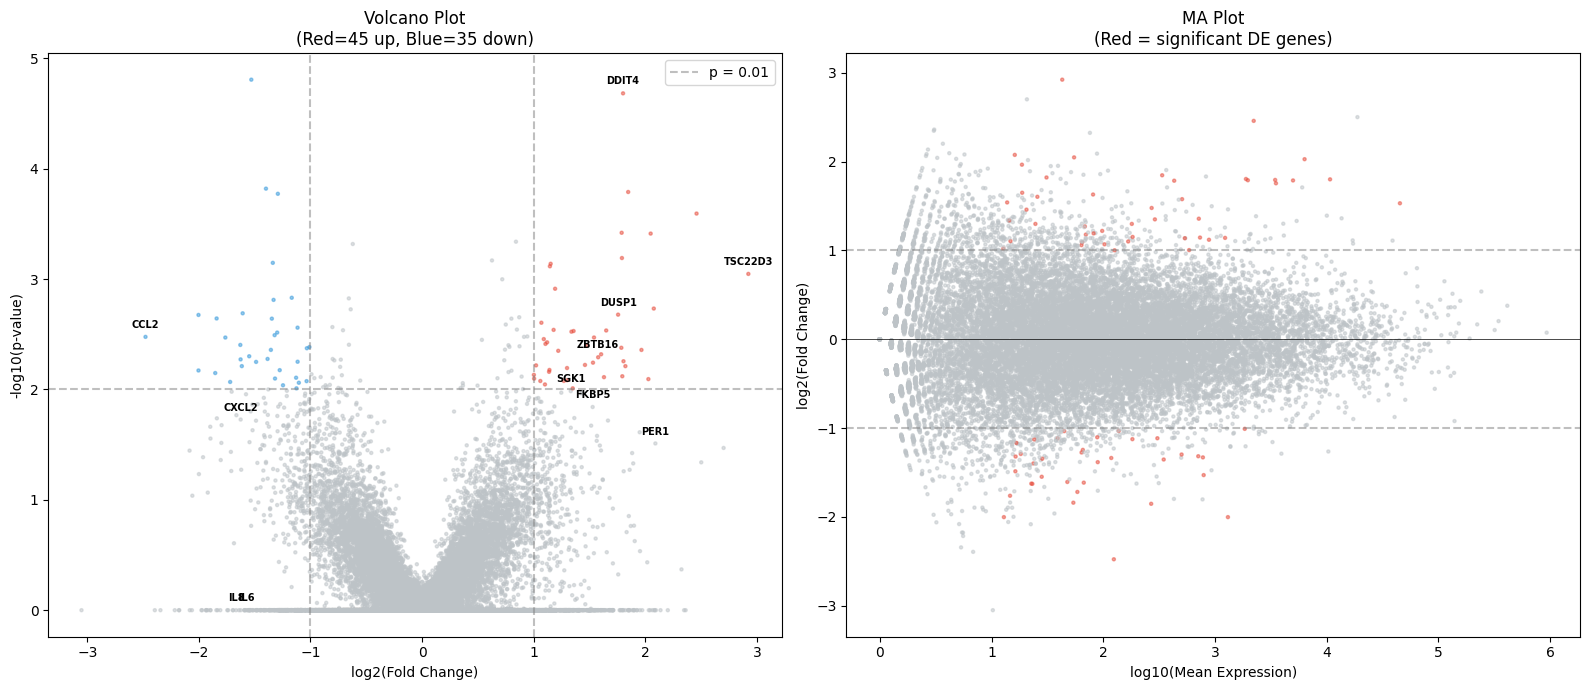

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Volcano plot (using nominal p-values for visualization)
neg_log_pval = -np.log10(pvalues + 1e-300)

colors_vol = np.where(sig_up, '#e74c3c', np.where(sig_down, '#3498db', '#bdc3c7'))
ax1.scatter(log2fc_observed, neg_log_pval, c=colors_vol, s=5, alpha=0.5)
ax1.axhline(-np.log10(0.01), color='gray', linestyle='--', alpha=0.5, label='p = 0.01')
ax1.axvline(1, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(-1, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('log2(Fold Change)')
ax1.set_ylabel('-log10(p-value)')
ax1.set_title(f'Volcano Plot\n(Red={sig_up.sum()} up, Blue={sig_down.sum()} down)')
ax1.legend()

# Label known dex-responsive genes on volcano plot
label_genes = ['FKBP5', 'TSC22D3', 'DUSP1', 'PER1', 'ZBTB16', 'DDIT4', 'SGK1',
               'IL8', 'IL6', 'CCL2', 'CXCL2']
for gene in label_genes:
    if gene in gene_names:
        idx = gene_names.index(gene)
        ax1.annotate(gene, (log2fc_observed[idx], neg_log_pval[idx]),
                     fontsize=7, fontweight='bold', ha='center', va='bottom',
                     xytext=(0, 5), textcoords='offset points')

# MA plot
mean_expression = np.log10(norm_counts.mean(axis=1) + 1)
colors_ma = np.where(sig_any, '#e74c3c', '#bdc3c7')
ax2.scatter(mean_expression, log2fc_observed, c=colors_ma, s=5, alpha=0.5)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axhline(1, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(-1, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('log10(Mean Expression)')
ax2.set_ylabel('log2(Fold Change)')
ax2.set_title('MA Plot\n(Red = significant DE genes)')

plt.tight_layout()
plt.show()

## Section 3: Heatmap and Clustering

Hierarchical clustering of DE genes reveals co-expression patterns. Genes that cluster
together may share regulatory mechanisms or pathways.

Z-score normalization per gene highlights relative changes across samples, removing
the effect of absolute expression level.

See [[Hierarchical Composition]] -- genes do not act alone; they form coordinated programs.

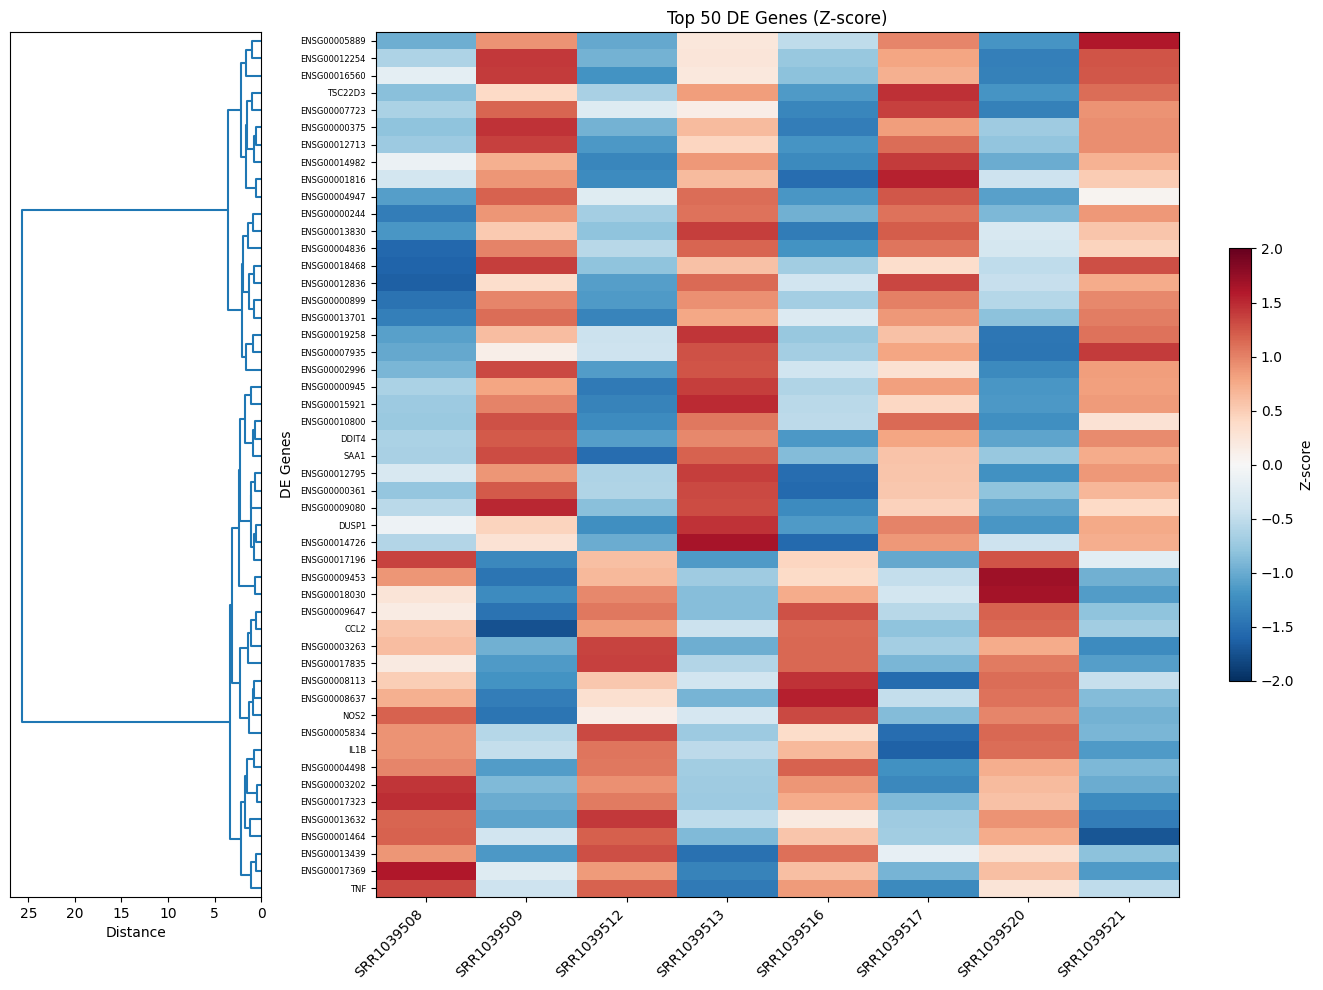

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Select top DE genes by p-value
top_de = np.argsort(pvalues)[:50]
de_data = np.log2(norm_counts[top_de] + 1)

# Z-score normalize per gene
de_zscore = (de_data - de_data.mean(axis=1, keepdims=True)) / (de_data.std(axis=1, keepdims=True) + 1e-10)

# Cluster genes
gene_linkage = linkage(de_zscore, method='ward')

fig, (ax_dendro, ax_heat) = plt.subplots(1, 2, figsize=(14, 10),
                                          gridspec_kw={'width_ratios': [1, 4]})

# Dendrogram
dn = dendrogram(gene_linkage, orientation='left', ax=ax_dendro, no_labels=True, color_threshold=0)
ax_dendro.set_xlabel('Distance')

# Heatmap (reordered by dendrogram)
order = dn['leaves']
im = ax_heat.imshow(de_zscore[order], aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
ax_heat.set_xticks(range(n_samples))
ax_heat.set_xticklabels(sample_names, rotation=45, ha='right')

# Show gene names on y-axis for top DE genes
top_gene_names = [gene_names[i] for i in top_de]
ordered_gene_names = [top_gene_names[i] for i in order]
ax_heat.set_yticks(range(len(order)))
ax_heat.set_yticklabels(ordered_gene_names, fontsize=6)
ax_heat.set_ylabel('DE Genes')
ax_heat.set_title('Top 50 DE Genes (Z-score)')
plt.colorbar(im, ax=ax_heat, label='Z-score', shrink=0.5)

plt.tight_layout()
plt.show()

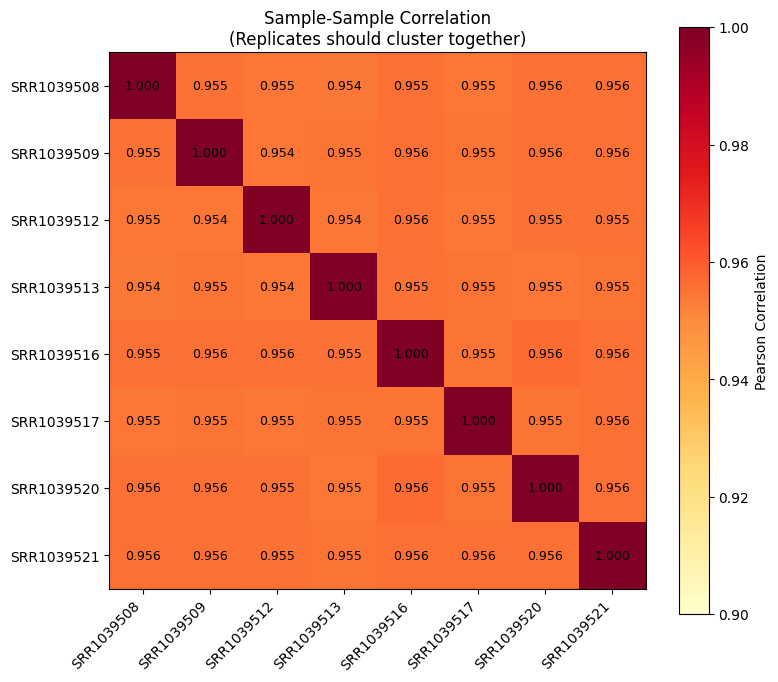

In [9]:
# Sample-sample correlation matrix
log_norm = np.log2(norm_counts + 1)
sample_corr = np.corrcoef(log_norm.T)

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(sample_corr, cmap='YlOrRd', vmin=0.9, vmax=1.0)
ax.set_xticks(range(n_samples))
ax.set_xticklabels(sample_names, rotation=45, ha='right')
ax.set_yticks(range(n_samples))
ax.set_yticklabels(sample_names)

for i in range(n_samples):
    for j in range(n_samples):
        ax.text(j, i, f'{sample_corr[i,j]:.3f}', ha='center', va='center', fontsize=9)

plt.colorbar(im, label='Pearson Correlation')
ax.set_title('Sample-Sample Correlation\n(Replicates should cluster together)')
plt.tight_layout()
plt.show()

## Section 4: Gene Set Enrichment

Individual DE genes are hard to interpret. Gene set enrichment analysis (GSEA) tests
whether predefined groups of genes (pathways, GO terms) are enriched among DE genes.

**Fisher's exact test** for overrepresentation:

|  | In pathway | Not in pathway |
|--|-----------|----------------|
| DE | a | b |
| Not DE | c | d |

$$p = P(X \geq a \mid \text{margins fixed})$$

See [[Perturbation-Response-Adaptation]] -- perturbation responses activate coherent gene
programs, not random individual genes. Enrichment analysis recovers these programs.

In [10]:
# Curated gene sets relevant to glucocorticoid response
pathway_gene_lists = {
    'Glucocorticoid Response': ['FKBP5', 'TSC22D3', 'DUSP1', 'PER1', 'KLF9', 'ZBTB16', 'SGK1', 'DDIT4'],
    'Inflammatory Response': ['IL8', 'IL6', 'CCL2', 'CXCL1', 'CXCL2', 'ICAM1', 'NFKBIA'],
    'Inflammatory Mediators': ['PTGS2', 'NOS2', 'TNF', 'IL1B', 'CSF2', 'CXCL3'],
    'ECM Remodeling': ['MMP1', 'MMP3', 'MMP9', 'VCAM1', 'SELE'],
    'Metabolic Regulation': ['PDK4', 'GLUL', 'TXNIP', 'ANGPTL4', 'IGFBP1'],
    'Stress Response': ['DDIT4', 'ERRFI1', 'CEBPD', 'MT2A', 'SAA1'],
}

# Convert gene names to indices, keeping only genes present in the dataset
pathways = {}
for name, genes in pathway_gene_lists.items():
    indices = [gene_names.index(g) for g in genes if g in gene_names]
    pathways[name] = np.array(indices)

# Also add some random background gene sets for comparison
np.random.seed(42)
pathways['Random Set A'] = np.random.choice(n_genes, 100, replace=False)
pathways['Random Set B'] = np.random.choice(n_genes, 150, replace=False)

# Fisher's exact test for enrichment
de_set = set(np.where(sig_any)[0])
all_genes_set = set(range(n_genes))

print(f"{'Pathway':<25} {'Size':>6} {'DE in set':>10} {'p-value':>10} {'Enriched?':>10}")
print("-" * 65)

pathway_pvals = {}
for name, genes in pathways.items():
    gene_set = set(genes)
    a = len(de_set & gene_set)  # DE and in pathway
    b = len(de_set - gene_set)  # DE and not in pathway
    c = len(gene_set - de_set)  # Not DE and in pathway
    d = len(all_genes_set - de_set - gene_set)  # Not DE and not in pathway
    
    odds_ratio, pval = stats.fisher_exact([[a, b], [c, d]], alternative='greater')
    pathway_pvals[name] = pval
    enriched = "YES" if pval < 0.05 else "no"
    print(f"{name:<25} {len(gene_set):>6} {a:>10} {pval:>10.4f} {enriched:>10}")

Pathway                     Size  DE in set    p-value  Enriched?
-----------------------------------------------------------------
Glucocorticoid Response        8          4     0.0000        YES
Inflammatory Response          7          2     0.0003        YES
Inflammatory Mediators         6          3     0.0000        YES
ECM Remodeling                 5          0     1.0000         no
Metabolic Regulation           5          4     0.0000        YES
Stress Response                5          3     0.0000        YES
Random Set A                 100          0     1.0000         no
Random Set B                 150          1     0.4531         no


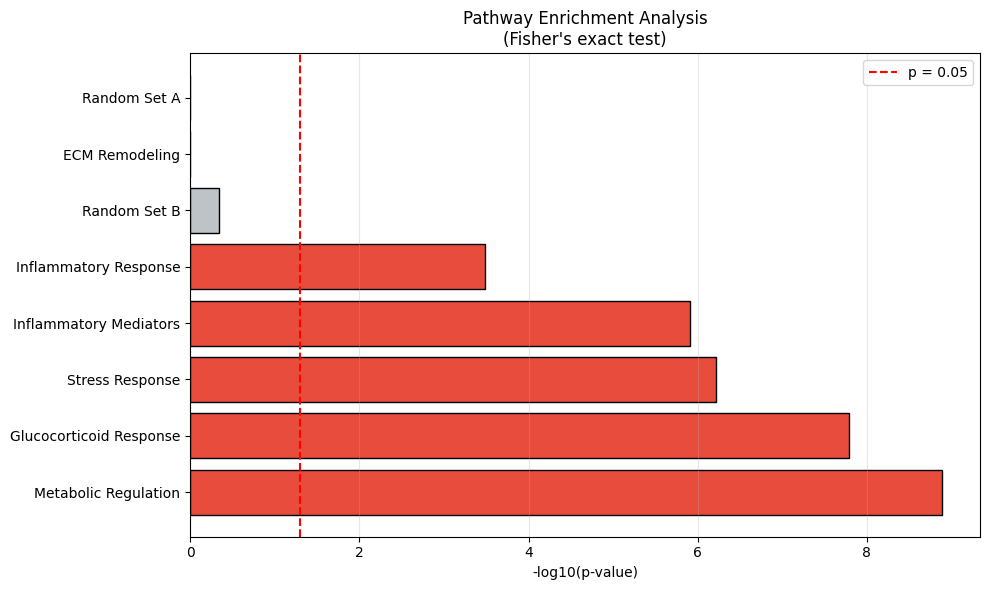

In [11]:
sorted_pathways = sorted(pathway_pvals.items(), key=lambda x: x[1])
names_pw = [p[0] for p in sorted_pathways]
pvals_pw = [p[1] for p in sorted_pathways]
neg_log_pvals = [-np.log10(p + 1e-10) for p in pvals_pw]

colors_pw = ['#e74c3c' if p < 0.05 else '#bdc3c7' for p in pvals_pw]

plt.figure(figsize=(10, 6))
plt.barh(names_pw, neg_log_pvals, color=colors_pw, edgecolor='black')
plt.axvline(-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.xlabel('-log10(p-value)')
plt.title("Pathway Enrichment Analysis\n(Fisher's exact test)")
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Summary

| Concept | What you built | Why it matters |
|---------|---------------|----------------|
| Count matrix | NB-distributed gene x sample | RNA-seq raw data format |
| Normalization | CPM, DESeq2, UQ methods | Make samples comparable |
| DE testing | Per-gene hypothesis testing | Find responsive genes |
| Multiple testing | Benjamini-Hochberg FDR | Control false discovery rate |
| Volcano plot | Effect size x significance | Visual DE summary |
| Heatmap | Clustered expression patterns | Co-expression programs |
| Pathway enrichment | Fisher's exact test on gene sets | Biological interpretation |

**Connections to conceptual framework:**
- [[Signal Processing in Biological Systems]]: Count data as noisy biological signal
- [[Perturbation-Response-Adaptation]]: DE genes are the molecular response to perturbation
- [[Hierarchical Composition]]: Genes form coordinated programs, not isolated actors
- [[Multi-Omics Integration]]: RNA-seq is one layer; proteomics, metabolomics add context
- [[Context Conditionality]]: Same gene may be DE in one tissue but not another
- [[Adaptive Response]]: Differential expression captures the cell's adaptive program

**Next**: [[06_Clinical_Biomedical_Informatics]] -- survival analysis, EHR data, clinical endpoints